# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline

import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

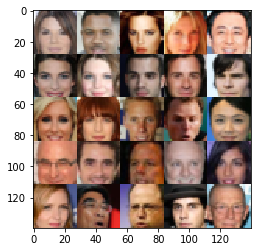

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_tensor = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="inputs")
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return input_tensor, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.02):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.02):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.02):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        # model_inputs(image_width, image_height, image_channels, z_dim)
        self.input_real, self.input_z, lr = model_inputs(real_size[1], real_size[2], real_size[3], z_size)
        # lr = learning_rate
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[3], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
        
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    net = GAN(data_shape, z_dim, learning_rate, beta1=beta1) 
    
    show_every = 100
    print_every = 10
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for steps, batch_images in enumerate(get_batches(batch_size)):
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Step {} of Epoch {}/{}...".format(steps, epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, net.input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 3.2809... Generator Loss: 0.0446
Epoch 1/2... Discriminator Loss: 0.4736... Generator Loss: 1.8891
Epoch 1/2... Discriminator Loss: 0.4741... Generator Loss: 1.2890
Epoch 1/2... Discriminator Loss: 0.6365... Generator Loss: 6.5443
Epoch 1/2... Discriminator Loss: 0.2957... Generator Loss: 5.3529
Epoch 1/2... Discriminator Loss: 0.1265... Generator Loss: 3.3677
Epoch 1/2... Discriminator Loss: 0.1024... Generator Loss: 2.8714
Epoch 1/2... Discriminator Loss: 0.5910... Generator Loss: 6.1451
Epoch 1/2... Discriminator Loss: 1.0845... Generator Loss: 1.0493
Epoch 1/2... Discriminator Loss: 0.8288... Generator Loss: 1.7988


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.5523... Generator Loss: 1.9008
Epoch 1/2... Discriminator Loss: 0.6314... Generator Loss: 1.3029
Epoch 1/2... Discriminator Loss: 0.6750... Generator Loss: 0.9328
Epoch 1/2... Discriminator Loss: 0.7048... Generator Loss: 0.9588
Epoch 1/2... Discriminator Loss: 0.6374... Generator Loss: 1.6091
Epoch 1/2... Discriminator Loss: 0.5386... Generator Loss: 1.8038
Epoch 1/2... Discriminator Loss: 0.6447... Generator Loss: 0.9800
Epoch 1/2... Discriminator Loss: 0.8657... Generator Loss: 3.0663
Epoch 1/2... Discriminator Loss: 1.3346... Generator Loss: 0.3850
Epoch 1/2... Discriminator Loss: 2.0094... Generator Loss: 0.2071


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.1330... Generator Loss: 1.5556
Epoch 1/2... Discriminator Loss: 0.8965... Generator Loss: 4.3454
Epoch 1/2... Discriminator Loss: 0.4078... Generator Loss: 3.0054
Epoch 1/2... Discriminator Loss: 0.4178... Generator Loss: 4.6084


IndexError: list index out of range

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 0 of Epoch 1/1... Discriminator Loss: 5.3654... Generator Loss: 0.0066


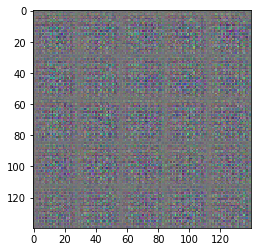

Step 10 of Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.3137
Step 20 of Epoch 1/1... Discriminator Loss: 0.1449... Generator Loss: 6.0478
Step 30 of Epoch 1/1... Discriminator Loss: 0.1510... Generator Loss: 2.4302
Step 40 of Epoch 1/1... Discriminator Loss: 0.1591... Generator Loss: 2.2120
Step 50 of Epoch 1/1... Discriminator Loss: 0.2845... Generator Loss: 10.1674
Step 60 of Epoch 1/1... Discriminator Loss: 0.0679... Generator Loss: 7.6631
Step 70 of Epoch 1/1... Discriminator Loss: 0.2445... Generator Loss: 1.9690
Step 80 of Epoch 1/1... Discriminator Loss: 0.2799... Generator Loss: 1.6953
Step 90 of Epoch 1/1... Discriminator Loss: 0.2802... Generator Loss: 1.6202
Step 100 of Epoch 1/1... Discriminator Loss: 0.4452... Generator Loss: 1.1739


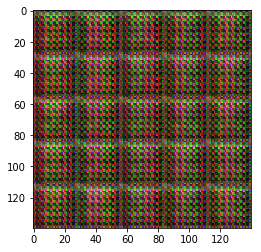

Step 110 of Epoch 1/1... Discriminator Loss: 0.5128... Generator Loss: 16.3701
Step 120 of Epoch 1/1... Discriminator Loss: 0.1317... Generator Loss: 4.5551
Step 130 of Epoch 1/1... Discriminator Loss: 0.2003... Generator Loss: 2.2140
Step 140 of Epoch 1/1... Discriminator Loss: 0.3263... Generator Loss: 1.4837
Step 150 of Epoch 1/1... Discriminator Loss: 0.2564... Generator Loss: 2.3413
Step 160 of Epoch 1/1... Discriminator Loss: 0.2962... Generator Loss: 1.7462
Step 170 of Epoch 1/1... Discriminator Loss: 0.1071... Generator Loss: 2.8735
Step 180 of Epoch 1/1... Discriminator Loss: 0.1835... Generator Loss: 2.0245
Step 190 of Epoch 1/1... Discriminator Loss: 0.1746... Generator Loss: 3.9659
Step 200 of Epoch 1/1... Discriminator Loss: 0.0973... Generator Loss: 5.0228


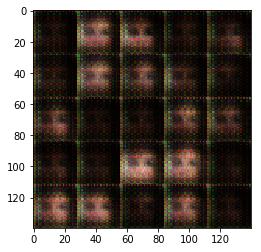

Step 210 of Epoch 1/1... Discriminator Loss: 0.1131... Generator Loss: 4.0676
Step 220 of Epoch 1/1... Discriminator Loss: 0.0260... Generator Loss: 4.0787
Step 230 of Epoch 1/1... Discriminator Loss: 0.1274... Generator Loss: 2.4736
Step 240 of Epoch 1/1... Discriminator Loss: 0.0993... Generator Loss: 4.0311
Step 250 of Epoch 1/1... Discriminator Loss: 0.1236... Generator Loss: 6.0179
Step 260 of Epoch 1/1... Discriminator Loss: 0.1300... Generator Loss: 2.6245
Step 270 of Epoch 1/1... Discriminator Loss: 1.7133... Generator Loss: 0.3871
Step 280 of Epoch 1/1... Discriminator Loss: 1.7456... Generator Loss: 0.3498
Step 290 of Epoch 1/1... Discriminator Loss: 0.2584... Generator Loss: 4.7113
Step 300 of Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 2.3449


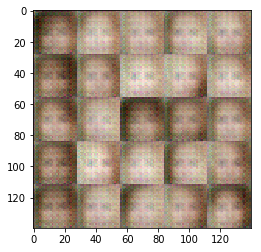

Step 310 of Epoch 1/1... Discriminator Loss: 0.4864... Generator Loss: 2.2482
Step 320 of Epoch 1/1... Discriminator Loss: 0.8862... Generator Loss: 0.9814
Step 330 of Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 0.9254
Step 340 of Epoch 1/1... Discriminator Loss: 0.3361... Generator Loss: 2.8513
Step 350 of Epoch 1/1... Discriminator Loss: 0.2906... Generator Loss: 4.4126
Step 360 of Epoch 1/1... Discriminator Loss: 0.2311... Generator Loss: 2.6488
Step 370 of Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 1.1268
Step 380 of Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.5115
Step 390 of Epoch 1/1... Discriminator Loss: 2.0626... Generator Loss: 0.2329
Step 400 of Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.4009


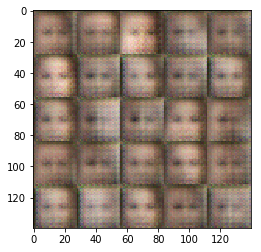

Step 410 of Epoch 1/1... Discriminator Loss: 0.2093... Generator Loss: 2.5360
Step 420 of Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 2.5994
Step 430 of Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 1.3662
Step 440 of Epoch 1/1... Discriminator Loss: 0.3297... Generator Loss: 4.2065
Step 450 of Epoch 1/1... Discriminator Loss: 0.5029... Generator Loss: 1.5979
Step 460 of Epoch 1/1... Discriminator Loss: 0.4534... Generator Loss: 2.0892
Step 470 of Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.8762
Step 480 of Epoch 1/1... Discriminator Loss: 0.7094... Generator Loss: 0.9960
Step 490 of Epoch 1/1... Discriminator Loss: 2.8863... Generator Loss: 0.0811
Step 500 of Epoch 1/1... Discriminator Loss: 0.4920... Generator Loss: 1.6547


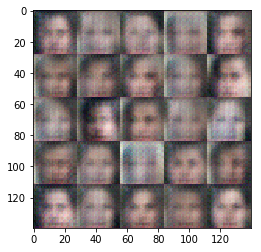

Step 510 of Epoch 1/1... Discriminator Loss: 0.6677... Generator Loss: 2.1063
Step 520 of Epoch 1/1... Discriminator Loss: 0.0945... Generator Loss: 3.8347
Step 530 of Epoch 1/1... Discriminator Loss: 0.3645... Generator Loss: 2.3055
Step 540 of Epoch 1/1... Discriminator Loss: 0.4701... Generator Loss: 1.3317
Step 550 of Epoch 1/1... Discriminator Loss: 0.4750... Generator Loss: 1.4827
Step 560 of Epoch 1/1... Discriminator Loss: 0.9126... Generator Loss: 0.7006
Step 570 of Epoch 1/1... Discriminator Loss: 0.2601... Generator Loss: 3.6606
Step 580 of Epoch 1/1... Discriminator Loss: 0.4987... Generator Loss: 1.8032
Step 590 of Epoch 1/1... Discriminator Loss: 0.4736... Generator Loss: 3.1297
Step 600 of Epoch 1/1... Discriminator Loss: 0.2060... Generator Loss: 2.4207


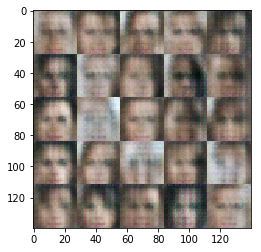

Step 610 of Epoch 1/1... Discriminator Loss: 0.0736... Generator Loss: 5.2878
Step 620 of Epoch 1/1... Discriminator Loss: 0.3442... Generator Loss: 2.1365
Step 630 of Epoch 1/1... Discriminator Loss: 0.1069... Generator Loss: 4.2150
Step 640 of Epoch 1/1... Discriminator Loss: 1.5882... Generator Loss: 4.9939
Step 650 of Epoch 1/1... Discriminator Loss: 0.1133... Generator Loss: 4.2662
Step 660 of Epoch 1/1... Discriminator Loss: 0.2935... Generator Loss: 2.4011
Step 670 of Epoch 1/1... Discriminator Loss: 0.0796... Generator Loss: 5.4620
Step 680 of Epoch 1/1... Discriminator Loss: 0.1358... Generator Loss: 4.7284
Step 690 of Epoch 1/1... Discriminator Loss: 0.1900... Generator Loss: 4.1206
Step 700 of Epoch 1/1... Discriminator Loss: 1.0857... Generator Loss: 0.5170


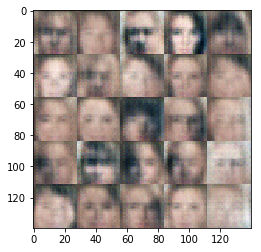

Step 710 of Epoch 1/1... Discriminator Loss: 0.3519... Generator Loss: 5.9843
Step 720 of Epoch 1/1... Discriminator Loss: 0.5495... Generator Loss: 1.4565
Step 730 of Epoch 1/1... Discriminator Loss: 0.4609... Generator Loss: 2.7253
Step 740 of Epoch 1/1... Discriminator Loss: 2.5167... Generator Loss: 0.1523
Step 750 of Epoch 1/1... Discriminator Loss: 0.3085... Generator Loss: 3.3281
Step 760 of Epoch 1/1... Discriminator Loss: 1.9265... Generator Loss: 0.2485
Step 770 of Epoch 1/1... Discriminator Loss: 0.3012... Generator Loss: 4.6746
Step 780 of Epoch 1/1... Discriminator Loss: 0.1269... Generator Loss: 2.6936
Step 790 of Epoch 1/1... Discriminator Loss: 0.2934... Generator Loss: 2.6600
Step 800 of Epoch 1/1... Discriminator Loss: 0.0705... Generator Loss: 6.4192


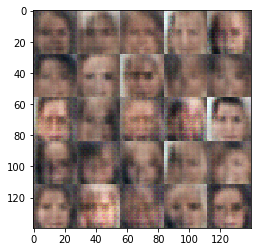

Step 810 of Epoch 1/1... Discriminator Loss: 0.0957... Generator Loss: 6.4053
Step 820 of Epoch 1/1... Discriminator Loss: 0.0430... Generator Loss: 5.9772
Step 830 of Epoch 1/1... Discriminator Loss: 0.1470... Generator Loss: 9.5162
Step 840 of Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 7.9683
Step 850 of Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 1.7505
Step 860 of Epoch 1/1... Discriminator Loss: 0.1243... Generator Loss: 2.8500
Step 870 of Epoch 1/1... Discriminator Loss: 0.3283... Generator Loss: 1.6522
Step 880 of Epoch 1/1... Discriminator Loss: 0.2700... Generator Loss: 2.5134
Step 890 of Epoch 1/1... Discriminator Loss: 0.3418... Generator Loss: 6.3258
Step 900 of Epoch 1/1... Discriminator Loss: 0.0238... Generator Loss: 7.2942


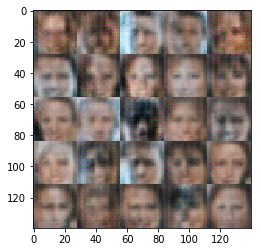

Step 910 of Epoch 1/1... Discriminator Loss: 0.2119... Generator Loss: 2.2865
Step 920 of Epoch 1/1... Discriminator Loss: 0.0213... Generator Loss: 5.8269
Step 930 of Epoch 1/1... Discriminator Loss: 0.1995... Generator Loss: 3.1876
Step 940 of Epoch 1/1... Discriminator Loss: 1.9290... Generator Loss: 4.0827
Step 950 of Epoch 1/1... Discriminator Loss: 0.4360... Generator Loss: 2.1363
Step 960 of Epoch 1/1... Discriminator Loss: 1.9695... Generator Loss: 0.2479
Step 970 of Epoch 1/1... Discriminator Loss: 0.6506... Generator Loss: 0.9480
Step 980 of Epoch 1/1... Discriminator Loss: 0.3877... Generator Loss: 1.6882
Step 990 of Epoch 1/1... Discriminator Loss: 0.1378... Generator Loss: 2.9764
Step 1000 of Epoch 1/1... Discriminator Loss: 0.4143... Generator Loss: 2.9650


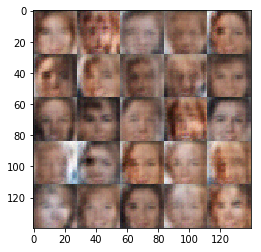

Step 1010 of Epoch 1/1... Discriminator Loss: 0.4599... Generator Loss: 1.5358
Step 1020 of Epoch 1/1... Discriminator Loss: 0.7414... Generator Loss: 1.9408
Step 1030 of Epoch 1/1... Discriminator Loss: 0.3584... Generator Loss: 5.1012
Step 1040 of Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 4.2077
Step 1050 of Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 1.2692
Step 1060 of Epoch 1/1... Discriminator Loss: 0.0695... Generator Loss: 6.7770
Step 1070 of Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 3.6311
Step 1080 of Epoch 1/1... Discriminator Loss: 0.7054... Generator Loss: 4.2653
Step 1090 of Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 0.5882
Step 1100 of Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 0.8316


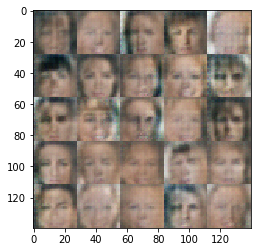

Step 1110 of Epoch 1/1... Discriminator Loss: 1.8985... Generator Loss: 0.2391
Step 1120 of Epoch 1/1... Discriminator Loss: 2.0999... Generator Loss: 0.2010
Step 1130 of Epoch 1/1... Discriminator Loss: 0.8546... Generator Loss: 4.5028
Step 1140 of Epoch 1/1... Discriminator Loss: 0.3809... Generator Loss: 3.7768
Step 1150 of Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 2.7207
Step 1160 of Epoch 1/1... Discriminator Loss: 0.5632... Generator Loss: 1.0951
Step 1170 of Epoch 1/1... Discriminator Loss: 0.0832... Generator Loss: 4.1717
Step 1180 of Epoch 1/1... Discriminator Loss: 0.1413... Generator Loss: 7.8982
Step 1190 of Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 1.1281
Step 1200 of Epoch 1/1... Discriminator Loss: 0.0529... Generator Loss: 7.0016


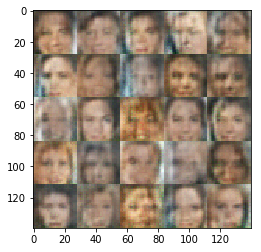

Step 1210 of Epoch 1/1... Discriminator Loss: 0.3477... Generator Loss: 3.9606
Step 1220 of Epoch 1/1... Discriminator Loss: 0.0910... Generator Loss: 4.6271
Step 1230 of Epoch 1/1... Discriminator Loss: 0.0705... Generator Loss: 5.7637
Step 1240 of Epoch 1/1... Discriminator Loss: 0.0302... Generator Loss: 10.9116
Step 1250 of Epoch 1/1... Discriminator Loss: 0.0637... Generator Loss: 3.2293
Step 1260 of Epoch 1/1... Discriminator Loss: 0.0151... Generator Loss: 5.8320
Step 1270 of Epoch 1/1... Discriminator Loss: 0.6759... Generator Loss: 0.9815
Step 1280 of Epoch 1/1... Discriminator Loss: 2.8296... Generator Loss: 0.8422
Step 1290 of Epoch 1/1... Discriminator Loss: 0.4760... Generator Loss: 1.5868
Step 1300 of Epoch 1/1... Discriminator Loss: 0.7366... Generator Loss: 1.1123


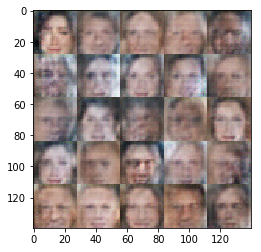

Step 1310 of Epoch 1/1... Discriminator Loss: 0.4930... Generator Loss: 1.2316
Step 1320 of Epoch 1/1... Discriminator Loss: 0.3455... Generator Loss: 7.6494
Step 1330 of Epoch 1/1... Discriminator Loss: 0.1463... Generator Loss: 3.5419
Step 1340 of Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.5459
Step 1350 of Epoch 1/1... Discriminator Loss: 0.6105... Generator Loss: 3.2728
Step 1360 of Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 0.8501
Step 1370 of Epoch 1/1... Discriminator Loss: 0.2759... Generator Loss: 2.4131
Step 1380 of Epoch 1/1... Discriminator Loss: 0.1060... Generator Loss: 7.0136
Step 1390 of Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 5.4539
Step 1400 of Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.4976


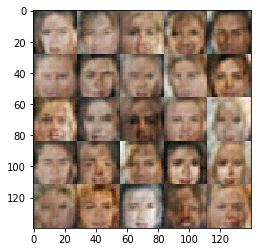

Step 1410 of Epoch 1/1... Discriminator Loss: 2.5759... Generator Loss: 0.1192
Step 1420 of Epoch 1/1... Discriminator Loss: 0.3662... Generator Loss: 1.5937
Step 1430 of Epoch 1/1... Discriminator Loss: 0.2311... Generator Loss: 2.5815
Step 1440 of Epoch 1/1... Discriminator Loss: 0.1286... Generator Loss: 8.3898
Step 1450 of Epoch 1/1... Discriminator Loss: 0.3163... Generator Loss: 9.0027
Step 1460 of Epoch 1/1... Discriminator Loss: 0.0655... Generator Loss: 5.5331
Step 1470 of Epoch 1/1... Discriminator Loss: 0.2479... Generator Loss: 6.0344
Step 1480 of Epoch 1/1... Discriminator Loss: 0.0915... Generator Loss: 5.4590
Step 1490 of Epoch 1/1... Discriminator Loss: 0.0609... Generator Loss: 6.5896
Step 1500 of Epoch 1/1... Discriminator Loss: 0.6800... Generator Loss: 4.1310


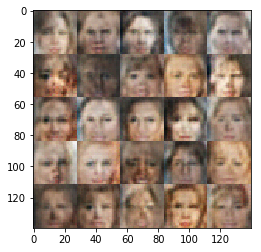

Step 1510 of Epoch 1/1... Discriminator Loss: 0.1472... Generator Loss: 4.9978
Step 1520 of Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 0.7432
Step 1530 of Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 0.6353
Step 1540 of Epoch 1/1... Discriminator Loss: 0.0563... Generator Loss: 6.8026
Step 1550 of Epoch 1/1... Discriminator Loss: 0.0056... Generator Loss: 5.8716
Step 1560 of Epoch 1/1... Discriminator Loss: 0.0844... Generator Loss: 4.2479
Step 1570 of Epoch 1/1... Discriminator Loss: 1.8986... Generator Loss: 10.9402
Step 1580 of Epoch 1/1... Discriminator Loss: 0.3804... Generator Loss: 2.0856
Step 1590 of Epoch 1/1... Discriminator Loss: 0.5068... Generator Loss: 1.4727
Step 1600 of Epoch 1/1... Discriminator Loss: 0.1950... Generator Loss: 3.7927


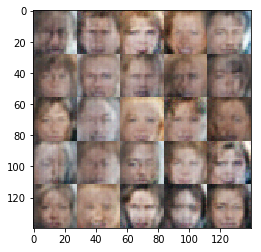

Step 1610 of Epoch 1/1... Discriminator Loss: 2.4313... Generator Loss: 0.1552
Step 1620 of Epoch 1/1... Discriminator Loss: 0.3707... Generator Loss: 1.3996
Step 1630 of Epoch 1/1... Discriminator Loss: 0.0253... Generator Loss: 10.9462
Step 1640 of Epoch 1/1... Discriminator Loss: 0.1643... Generator Loss: 7.5343
Step 1650 of Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 1.7254
Step 1660 of Epoch 1/1... Discriminator Loss: 0.1238... Generator Loss: 2.6564
Step 1670 of Epoch 1/1... Discriminator Loss: 0.4111... Generator Loss: 1.8973
Step 1680 of Epoch 1/1... Discriminator Loss: 0.1328... Generator Loss: 7.9278
Step 1690 of Epoch 1/1... Discriminator Loss: 0.4420... Generator Loss: 3.7963
Step 1700 of Epoch 1/1... Discriminator Loss: 0.1722... Generator Loss: 6.0344


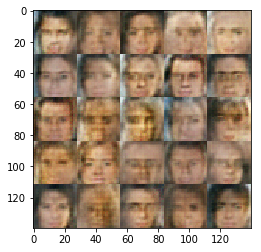

Step 1710 of Epoch 1/1... Discriminator Loss: 0.2994... Generator Loss: 1.8479
Step 1720 of Epoch 1/1... Discriminator Loss: 0.0503... Generator Loss: 3.9434
Step 1730 of Epoch 1/1... Discriminator Loss: 0.1008... Generator Loss: 3.0445
Step 1740 of Epoch 1/1... Discriminator Loss: 0.1387... Generator Loss: 6.0779
Step 1750 of Epoch 1/1... Discriminator Loss: 0.0699... Generator Loss: 10.1124
Step 1760 of Epoch 1/1... Discriminator Loss: 0.0821... Generator Loss: 7.1621
Step 1770 of Epoch 1/1... Discriminator Loss: 0.0077... Generator Loss: 8.5215
Step 1780 of Epoch 1/1... Discriminator Loss: 0.0480... Generator Loss: 12.1383
Step 1790 of Epoch 1/1... Discriminator Loss: 0.6500... Generator Loss: 1.1622
Step 1800 of Epoch 1/1... Discriminator Loss: 0.0531... Generator Loss: 7.7590


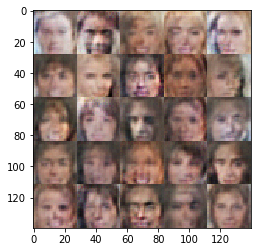

Step 1810 of Epoch 1/1... Discriminator Loss: 0.0100... Generator Loss: 7.3618
Step 1820 of Epoch 1/1... Discriminator Loss: 0.0172... Generator Loss: 9.7907
Step 1830 of Epoch 1/1... Discriminator Loss: 0.0387... Generator Loss: 7.5812
Step 1840 of Epoch 1/1... Discriminator Loss: 0.0120... Generator Loss: 7.1135
Step 1850 of Epoch 1/1... Discriminator Loss: 0.3147... Generator Loss: 1.6975
Step 1860 of Epoch 1/1... Discriminator Loss: 0.0895... Generator Loss: 3.7164
Step 1870 of Epoch 1/1... Discriminator Loss: 0.0277... Generator Loss: 11.2132
Step 1880 of Epoch 1/1... Discriminator Loss: 0.0714... Generator Loss: 13.9329
Step 1890 of Epoch 1/1... Discriminator Loss: 0.0356... Generator Loss: 4.0003
Step 1900 of Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 12.7240


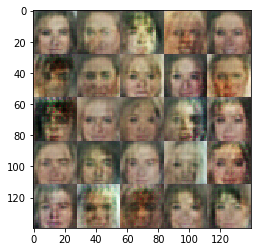

Step 1910 of Epoch 1/1... Discriminator Loss: 0.0200... Generator Loss: 4.8051
Step 1920 of Epoch 1/1... Discriminator Loss: 0.1096... Generator Loss: 2.9462
Step 1930 of Epoch 1/1... Discriminator Loss: 0.0599... Generator Loss: 3.7971
Step 1940 of Epoch 1/1... Discriminator Loss: 0.0283... Generator Loss: 6.8489
Step 1950 of Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 0.7790
Step 1960 of Epoch 1/1... Discriminator Loss: 1.6498... Generator Loss: 0.4074
Step 1970 of Epoch 1/1... Discriminator Loss: 1.7342... Generator Loss: 0.3268
Step 1980 of Epoch 1/1... Discriminator Loss: 0.3470... Generator Loss: 2.1338
Step 1990 of Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.6281
Step 2000 of Epoch 1/1... Discriminator Loss: 0.3756... Generator Loss: 2.9477


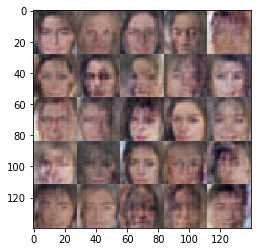

Step 2010 of Epoch 1/1... Discriminator Loss: 0.0419... Generator Loss: 6.5014
Step 2020 of Epoch 1/1... Discriminator Loss: 0.1222... Generator Loss: 3.2822
Step 2030 of Epoch 1/1... Discriminator Loss: 0.0511... Generator Loss: 7.7571
Step 2040 of Epoch 1/1... Discriminator Loss: 0.3560... Generator Loss: 1.7211
Step 2050 of Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 0.7828
Step 2060 of Epoch 1/1... Discriminator Loss: 0.3953... Generator Loss: 1.9285
Step 2070 of Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.3188
Step 2080 of Epoch 1/1... Discriminator Loss: 0.4381... Generator Loss: 7.0738
Step 2090 of Epoch 1/1... Discriminator Loss: 0.1349... Generator Loss: 2.8944
Step 2100 of Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 5.3026


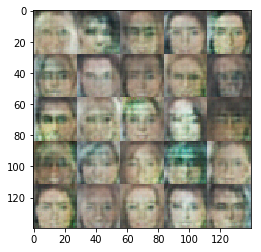

Step 2110 of Epoch 1/1... Discriminator Loss: 0.6681... Generator Loss: 1.5086
Step 2120 of Epoch 1/1... Discriminator Loss: 0.5312... Generator Loss: 1.0959
Step 2130 of Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 1.0751
Step 2140 of Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.4961
Step 2150 of Epoch 1/1... Discriminator Loss: 0.2517... Generator Loss: 2.9059
Step 2160 of Epoch 1/1... Discriminator Loss: 0.2497... Generator Loss: 2.9426
Step 2170 of Epoch 1/1... Discriminator Loss: 0.2284... Generator Loss: 3.6502
Step 2180 of Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 2.3265
Step 2190 of Epoch 1/1... Discriminator Loss: 0.2655... Generator Loss: 2.0781
Step 2200 of Epoch 1/1... Discriminator Loss: 0.0196... Generator Loss: 10.4592


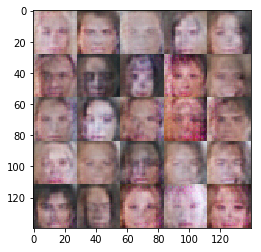

Step 2210 of Epoch 1/1... Discriminator Loss: 0.0957... Generator Loss: 6.0470
Step 2220 of Epoch 1/1... Discriminator Loss: 0.3209... Generator Loss: 2.1219
Step 2230 of Epoch 1/1... Discriminator Loss: 0.2910... Generator Loss: 2.1207
Step 2240 of Epoch 1/1... Discriminator Loss: 0.0341... Generator Loss: 4.5470
Step 2250 of Epoch 1/1... Discriminator Loss: 0.2562... Generator Loss: 2.1696
Step 2260 of Epoch 1/1... Discriminator Loss: 0.1142... Generator Loss: 2.5976
Step 2270 of Epoch 1/1... Discriminator Loss: 0.0160... Generator Loss: 9.9604
Step 2280 of Epoch 1/1... Discriminator Loss: 0.0933... Generator Loss: 10.8194
Step 2290 of Epoch 1/1... Discriminator Loss: 0.2016... Generator Loss: 3.7661
Step 2300 of Epoch 1/1... Discriminator Loss: 4.6983... Generator Loss: 0.0137


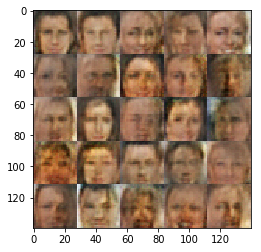

Step 2310 of Epoch 1/1... Discriminator Loss: 0.7370... Generator Loss: 1.1600
Step 2320 of Epoch 1/1... Discriminator Loss: 0.6931... Generator Loss: 0.8920
Step 2330 of Epoch 1/1... Discriminator Loss: 0.8485... Generator Loss: 0.9969
Step 2340 of Epoch 1/1... Discriminator Loss: 0.1126... Generator Loss: 4.6064
Step 2350 of Epoch 1/1... Discriminator Loss: 2.8734... Generator Loss: 0.0910
Step 2360 of Epoch 1/1... Discriminator Loss: 0.0385... Generator Loss: 4.6482
Step 2370 of Epoch 1/1... Discriminator Loss: 0.1702... Generator Loss: 2.6120
Step 2380 of Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 3.6387
Step 2390 of Epoch 1/1... Discriminator Loss: 0.0425... Generator Loss: 9.6408
Step 2400 of Epoch 1/1... Discriminator Loss: 0.0635... Generator Loss: 4.4639


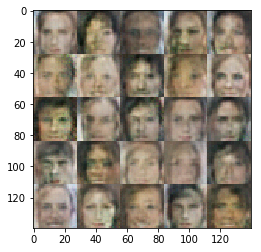

Step 2410 of Epoch 1/1... Discriminator Loss: 0.3305... Generator Loss: 4.5392
Step 2420 of Epoch 1/1... Discriminator Loss: 0.0256... Generator Loss: 11.6118
Step 2430 of Epoch 1/1... Discriminator Loss: 0.8165... Generator Loss: 0.8263
Step 2440 of Epoch 1/1... Discriminator Loss: 0.0403... Generator Loss: 4.1034
Step 2450 of Epoch 1/1... Discriminator Loss: 0.1135... Generator Loss: 7.7123
Step 2460 of Epoch 1/1... Discriminator Loss: 0.1356... Generator Loss: 4.1885
Step 2470 of Epoch 1/1... Discriminator Loss: 0.0159... Generator Loss: 10.0977
Step 2480 of Epoch 1/1... Discriminator Loss: 0.0653... Generator Loss: 4.0363
Step 2490 of Epoch 1/1... Discriminator Loss: 0.0371... Generator Loss: 14.5941
Step 2500 of Epoch 1/1... Discriminator Loss: 1.8923... Generator Loss: 3.3751


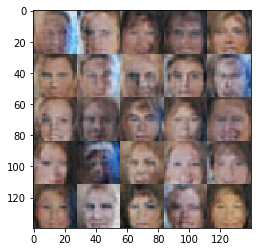

Step 2510 of Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 1.7086
Step 2520 of Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 0.7171
Step 2530 of Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.3925
Step 2540 of Epoch 1/1... Discriminator Loss: 0.5936... Generator Loss: 1.2849
Step 2550 of Epoch 1/1... Discriminator Loss: 0.2928... Generator Loss: 2.2408
Step 2560 of Epoch 1/1... Discriminator Loss: 0.3248... Generator Loss: 3.9868
Step 2570 of Epoch 1/1... Discriminator Loss: 0.2418... Generator Loss: 2.3393
Step 2580 of Epoch 1/1... Discriminator Loss: 0.4372... Generator Loss: 1.4578
Step 2590 of Epoch 1/1... Discriminator Loss: 0.0430... Generator Loss: 6.3032
Step 2600 of Epoch 1/1... Discriminator Loss: 0.1004... Generator Loss: 6.7655


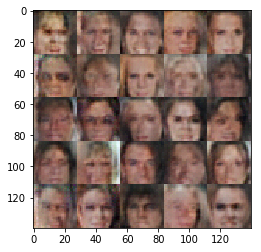

Step 2610 of Epoch 1/1... Discriminator Loss: 1.0790... Generator Loss: 0.5875
Step 2620 of Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 3.1190
Step 2630 of Epoch 1/1... Discriminator Loss: 0.0957... Generator Loss: 7.9673
Step 2640 of Epoch 1/1... Discriminator Loss: 0.0201... Generator Loss: 5.4097
Step 2650 of Epoch 1/1... Discriminator Loss: 0.3337... Generator Loss: 2.9398
Step 2660 of Epoch 1/1... Discriminator Loss: 0.2961... Generator Loss: 2.1725
Step 2670 of Epoch 1/1... Discriminator Loss: 0.0259... Generator Loss: 9.0996
Step 2680 of Epoch 1/1... Discriminator Loss: 0.4235... Generator Loss: 1.7727
Step 2690 of Epoch 1/1... Discriminator Loss: 0.2470... Generator Loss: 2.3834
Step 2700 of Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 7.3054


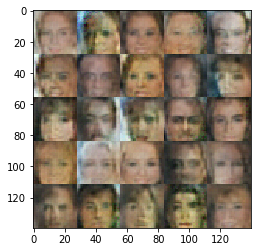

Step 2710 of Epoch 1/1... Discriminator Loss: 0.3549... Generator Loss: 1.8704
Step 2720 of Epoch 1/1... Discriminator Loss: 0.2104... Generator Loss: 2.9950
Step 2730 of Epoch 1/1... Discriminator Loss: 0.3576... Generator Loss: 1.7081
Step 2740 of Epoch 1/1... Discriminator Loss: 0.4912... Generator Loss: 1.1635
Step 2750 of Epoch 1/1... Discriminator Loss: 0.1082... Generator Loss: 10.4516
Step 2760 of Epoch 1/1... Discriminator Loss: 0.0738... Generator Loss: 4.4149
Step 2770 of Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.6071
Step 2780 of Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.5327
Step 2790 of Epoch 1/1... Discriminator Loss: 0.8687... Generator Loss: 1.0772
Step 2800 of Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 4.3610


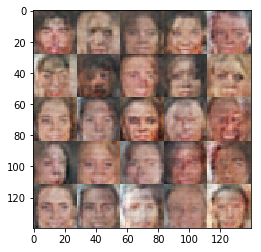

Step 2810 of Epoch 1/1... Discriminator Loss: 0.2462... Generator Loss: 3.0239
Step 2820 of Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 0.4983
Step 2830 of Epoch 1/1... Discriminator Loss: 0.0675... Generator Loss: 4.6313
Step 2840 of Epoch 1/1... Discriminator Loss: 0.0326... Generator Loss: 5.8735
Step 2850 of Epoch 1/1... Discriminator Loss: 0.2367... Generator Loss: 2.2201
Step 2860 of Epoch 1/1... Discriminator Loss: 0.0782... Generator Loss: 5.1722
Step 2870 of Epoch 1/1... Discriminator Loss: 0.1863... Generator Loss: 2.4005
Step 2880 of Epoch 1/1... Discriminator Loss: 0.0942... Generator Loss: 3.4917
Step 2890 of Epoch 1/1... Discriminator Loss: 0.0190... Generator Loss: 6.4692
Step 2900 of Epoch 1/1... Discriminator Loss: 0.1988... Generator Loss: 8.6378


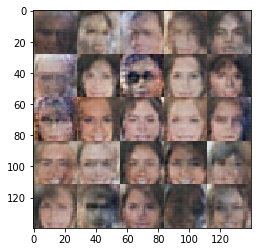

Step 2910 of Epoch 1/1... Discriminator Loss: 0.1596... Generator Loss: 6.1690
Step 2920 of Epoch 1/1... Discriminator Loss: 1.9346... Generator Loss: 0.2245
Step 2930 of Epoch 1/1... Discriminator Loss: 0.7210... Generator Loss: 1.0038
Step 2940 of Epoch 1/1... Discriminator Loss: 0.6263... Generator Loss: 1.2865
Step 2950 of Epoch 1/1... Discriminator Loss: 0.4748... Generator Loss: 1.4803
Step 2960 of Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.6186
Step 2970 of Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 1.0881
Step 2980 of Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.5349
Step 2990 of Epoch 1/1... Discriminator Loss: 0.3873... Generator Loss: 1.7889
Step 3000 of Epoch 1/1... Discriminator Loss: 0.9167... Generator Loss: 0.9489


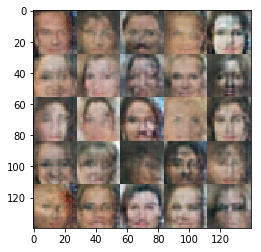

Step 3010 of Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 0.6722
Step 3020 of Epoch 1/1... Discriminator Loss: 0.0746... Generator Loss: 3.6349
Step 3030 of Epoch 1/1... Discriminator Loss: 0.0686... Generator Loss: 8.3209
Step 3040 of Epoch 1/1... Discriminator Loss: 0.1094... Generator Loss: 4.4271
Step 3050 of Epoch 1/1... Discriminator Loss: 0.1274... Generator Loss: 3.6841
Step 3060 of Epoch 1/1... Discriminator Loss: 0.2256... Generator Loss: 1.9856
Step 3070 of Epoch 1/1... Discriminator Loss: 0.6307... Generator Loss: 1.5165
Step 3080 of Epoch 1/1... Discriminator Loss: 0.2104... Generator Loss: 4.5281
Step 3090 of Epoch 1/1... Discriminator Loss: 0.3338... Generator Loss: 1.6942
Step 3100 of Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 0.7328


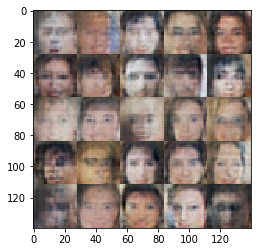

Step 3110 of Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 0.7726
Step 3120 of Epoch 1/1... Discriminator Loss: 0.3964... Generator Loss: 3.9915
Step 3130 of Epoch 1/1... Discriminator Loss: 0.0509... Generator Loss: 4.6450
Step 3140 of Epoch 1/1... Discriminator Loss: 0.2737... Generator Loss: 1.7548
Step 3150 of Epoch 1/1... Discriminator Loss: 0.1474... Generator Loss: 2.7597
Step 3160 of Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 0.9530
Step 3170 of Epoch 1/1... Discriminator Loss: 0.0787... Generator Loss: 4.6123
Step 3180 of Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.4417
Step 3190 of Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 1.5506
Step 3200 of Epoch 1/1... Discriminator Loss: 0.2035... Generator Loss: 2.6301


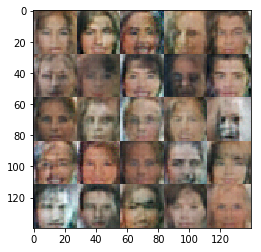

Step 3210 of Epoch 1/1... Discriminator Loss: 0.4431... Generator Loss: 1.6601
Step 3220 of Epoch 1/1... Discriminator Loss: 0.0513... Generator Loss: 4.1744
Step 3230 of Epoch 1/1... Discriminator Loss: 1.7662... Generator Loss: 0.2815
Step 3240 of Epoch 1/1... Discriminator Loss: 0.1496... Generator Loss: 2.8840
Step 3250 of Epoch 1/1... Discriminator Loss: 0.3516... Generator Loss: 2.0286
Step 3260 of Epoch 1/1... Discriminator Loss: 0.3781... Generator Loss: 6.4845
Step 3270 of Epoch 1/1... Discriminator Loss: 0.8984... Generator Loss: 0.6825
Step 3280 of Epoch 1/1... Discriminator Loss: 0.1819... Generator Loss: 3.0731
Step 3290 of Epoch 1/1... Discriminator Loss: 1.6430... Generator Loss: 0.3171
Step 3300 of Epoch 1/1... Discriminator Loss: 0.0525... Generator Loss: 4.0770


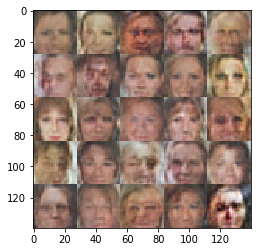

Step 3310 of Epoch 1/1... Discriminator Loss: 0.0591... Generator Loss: 4.1733
Step 3320 of Epoch 1/1... Discriminator Loss: 0.1164... Generator Loss: 7.5295
Step 3330 of Epoch 1/1... Discriminator Loss: 0.3029... Generator Loss: 1.6547
Step 3340 of Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 0.6780
Step 3350 of Epoch 1/1... Discriminator Loss: 0.1104... Generator Loss: 3.3137
Step 3360 of Epoch 1/1... Discriminator Loss: 2.8867... Generator Loss: 0.0787
Step 3370 of Epoch 1/1... Discriminator Loss: 0.6282... Generator Loss: 1.3561
Step 3380 of Epoch 1/1... Discriminator Loss: 0.5257... Generator Loss: 1.8763
Step 3390 of Epoch 1/1... Discriminator Loss: 0.1051... Generator Loss: 4.1597
Step 3400 of Epoch 1/1... Discriminator Loss: 0.2466... Generator Loss: 2.7993


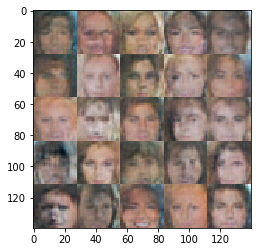

Step 3410 of Epoch 1/1... Discriminator Loss: 0.1890... Generator Loss: 2.5545
Step 3420 of Epoch 1/1... Discriminator Loss: 0.6573... Generator Loss: 3.1641
Step 3430 of Epoch 1/1... Discriminator Loss: 0.6278... Generator Loss: 1.5221
Step 3440 of Epoch 1/1... Discriminator Loss: 0.4905... Generator Loss: 1.6772
Step 3450 of Epoch 1/1... Discriminator Loss: 0.9501... Generator Loss: 0.8381
Step 3460 of Epoch 1/1... Discriminator Loss: 0.6210... Generator Loss: 1.1838
Step 3470 of Epoch 1/1... Discriminator Loss: 0.2485... Generator Loss: 2.1251
Step 3480 of Epoch 1/1... Discriminator Loss: 0.5339... Generator Loss: 1.3303
Step 3490 of Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 1.3798
Step 3500 of Epoch 1/1... Discriminator Loss: 0.2363... Generator Loss: 3.2539


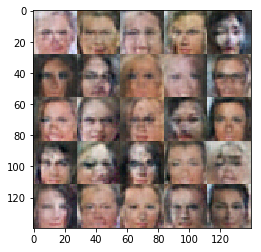

Step 3510 of Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.8023
Step 3520 of Epoch 1/1... Discriminator Loss: 0.1248... Generator Loss: 5.1762
Step 3530 of Epoch 1/1... Discriminator Loss: 0.0380... Generator Loss: 5.2130
Step 3540 of Epoch 1/1... Discriminator Loss: 0.0349... Generator Loss: 6.1265
Step 3550 of Epoch 1/1... Discriminator Loss: 0.0565... Generator Loss: 4.4638
Step 3560 of Epoch 1/1... Discriminator Loss: 0.0616... Generator Loss: 5.1272
Step 3570 of Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 1.0443
Step 3580 of Epoch 1/1... Discriminator Loss: 1.8803... Generator Loss: 0.3581
Step 3590 of Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.6777
Step 3600 of Epoch 1/1... Discriminator Loss: 0.4027... Generator Loss: 1.6230


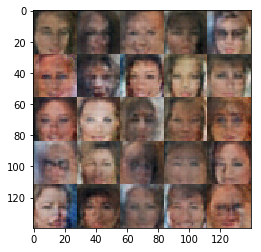

Step 3610 of Epoch 1/1... Discriminator Loss: 0.2300... Generator Loss: 2.2063
Step 3620 of Epoch 1/1... Discriminator Loss: 0.0293... Generator Loss: 7.0088
Step 3630 of Epoch 1/1... Discriminator Loss: 0.1752... Generator Loss: 4.0331
Step 3640 of Epoch 1/1... Discriminator Loss: 0.1021... Generator Loss: 3.2842
Step 3650 of Epoch 1/1... Discriminator Loss: 0.1549... Generator Loss: 2.8646
Step 3660 of Epoch 1/1... Discriminator Loss: 0.1650... Generator Loss: 2.4937
Step 3670 of Epoch 1/1... Discriminator Loss: 0.1301... Generator Loss: 3.1997
Step 3680 of Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.6136
Step 3690 of Epoch 1/1... Discriminator Loss: 2.1881... Generator Loss: 0.2029
Step 3700 of Epoch 1/1... Discriminator Loss: 0.3525... Generator Loss: 2.0052


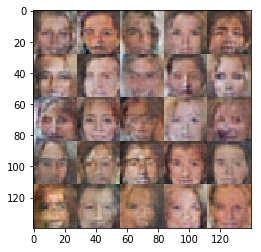

Step 3710 of Epoch 1/1... Discriminator Loss: 0.1797... Generator Loss: 2.8769
Step 3720 of Epoch 1/1... Discriminator Loss: 0.1126... Generator Loss: 5.4612
Step 3730 of Epoch 1/1... Discriminator Loss: 0.2373... Generator Loss: 2.3811
Step 3740 of Epoch 1/1... Discriminator Loss: 0.1820... Generator Loss: 5.2829
Step 3750 of Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 5.8494
Step 3760 of Epoch 1/1... Discriminator Loss: 0.6978... Generator Loss: 1.0529
Step 3770 of Epoch 1/1... Discriminator Loss: 0.3123... Generator Loss: 1.8858
Step 3780 of Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.4184
Step 3790 of Epoch 1/1... Discriminator Loss: 0.4607... Generator Loss: 1.7210
Step 3800 of Epoch 1/1... Discriminator Loss: 0.2201... Generator Loss: 2.1950


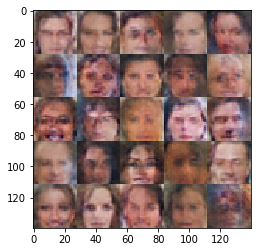

Step 3810 of Epoch 1/1... Discriminator Loss: 0.3325... Generator Loss: 2.1467
Step 3820 of Epoch 1/1... Discriminator Loss: 0.2489... Generator Loss: 4.9478
Step 3830 of Epoch 1/1... Discriminator Loss: 0.6759... Generator Loss: 1.0118
Step 3840 of Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 0.7870
Step 3850 of Epoch 1/1... Discriminator Loss: 0.1206... Generator Loss: 3.1778
Step 3860 of Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 1.7233
Step 3870 of Epoch 1/1... Discriminator Loss: 0.2647... Generator Loss: 3.2879
Step 3880 of Epoch 1/1... Discriminator Loss: 0.0657... Generator Loss: 4.7344
Step 3890 of Epoch 1/1... Discriminator Loss: 0.7922... Generator Loss: 2.7388
Step 3900 of Epoch 1/1... Discriminator Loss: 0.2945... Generator Loss: 2.3019


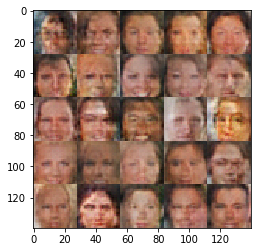

Step 3910 of Epoch 1/1... Discriminator Loss: 0.1200... Generator Loss: 3.3009
Step 3920 of Epoch 1/1... Discriminator Loss: 0.2478... Generator Loss: 6.8829
Step 3930 of Epoch 1/1... Discriminator Loss: 0.7814... Generator Loss: 0.9324
Step 3940 of Epoch 1/1... Discriminator Loss: 0.2284... Generator Loss: 2.0884
Step 3950 of Epoch 1/1... Discriminator Loss: 0.1742... Generator Loss: 6.4656
Step 3960 of Epoch 1/1... Discriminator Loss: 0.1035... Generator Loss: 3.6588
Step 3970 of Epoch 1/1... Discriminator Loss: 0.0630... Generator Loss: 5.2300
Step 3980 of Epoch 1/1... Discriminator Loss: 0.2480... Generator Loss: 2.3940
Step 3990 of Epoch 1/1... Discriminator Loss: 0.0612... Generator Loss: 9.8318
Step 4000 of Epoch 1/1... Discriminator Loss: 3.5397... Generator Loss: 0.0413


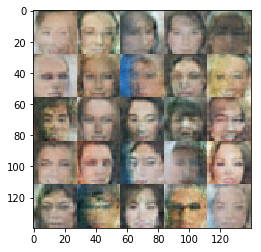

Step 4010 of Epoch 1/1... Discriminator Loss: 0.3539... Generator Loss: 1.7324
Step 4020 of Epoch 1/1... Discriminator Loss: 0.4777... Generator Loss: 7.3834
Step 4030 of Epoch 1/1... Discriminator Loss: 0.1889... Generator Loss: 3.0369
Step 4040 of Epoch 1/1... Discriminator Loss: 0.1269... Generator Loss: 3.5048
Step 4050 of Epoch 1/1... Discriminator Loss: 0.0475... Generator Loss: 5.5910
Step 4060 of Epoch 1/1... Discriminator Loss: 0.1833... Generator Loss: 2.6400
Step 4070 of Epoch 1/1... Discriminator Loss: 0.0575... Generator Loss: 6.4689
Step 4080 of Epoch 1/1... Discriminator Loss: 0.1997... Generator Loss: 2.8259
Step 4090 of Epoch 1/1... Discriminator Loss: 0.2545... Generator Loss: 2.2660
Step 4100 of Epoch 1/1... Discriminator Loss: 0.0495... Generator Loss: 5.3420


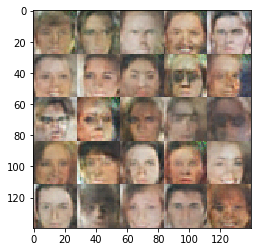

Step 4110 of Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 4.0286
Step 4120 of Epoch 1/1... Discriminator Loss: 0.4726... Generator Loss: 1.5281
Step 4130 of Epoch 1/1... Discriminator Loss: 0.4894... Generator Loss: 2.1639
Step 4140 of Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 0.8107
Step 4150 of Epoch 1/1... Discriminator Loss: 0.3126... Generator Loss: 2.1449
Step 4160 of Epoch 1/1... Discriminator Loss: 0.2542... Generator Loss: 2.2715
Step 4170 of Epoch 1/1... Discriminator Loss: 0.4821... Generator Loss: 1.4855
Step 4180 of Epoch 1/1... Discriminator Loss: 0.0272... Generator Loss: 8.1167
Step 4190 of Epoch 1/1... Discriminator Loss: 0.1931... Generator Loss: 3.8392
Step 4200 of Epoch 1/1... Discriminator Loss: 1.8745... Generator Loss: 0.3381


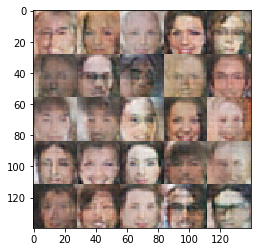

Step 4210 of Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.5096
Step 4220 of Epoch 1/1... Discriminator Loss: 0.3092... Generator Loss: 2.0512
Step 4230 of Epoch 1/1... Discriminator Loss: 0.2235... Generator Loss: 9.0732
Step 4240 of Epoch 1/1... Discriminator Loss: 1.7812... Generator Loss: 0.2815
Step 4250 of Epoch 1/1... Discriminator Loss: 0.2029... Generator Loss: 2.6162
Step 4260 of Epoch 1/1... Discriminator Loss: 0.4014... Generator Loss: 1.6654
Step 4270 of Epoch 1/1... Discriminator Loss: 0.1188... Generator Loss: 6.6115
Step 4280 of Epoch 1/1... Discriminator Loss: 0.1638... Generator Loss: 6.8808
Step 4290 of Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 0.5860
Step 4300 of Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 1.4869


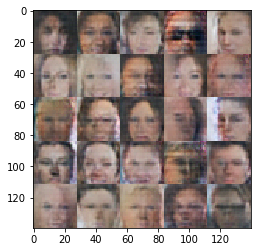

Step 4310 of Epoch 1/1... Discriminator Loss: 0.3463... Generator Loss: 1.6887
Step 4320 of Epoch 1/1... Discriminator Loss: 0.6250... Generator Loss: 5.2083
Step 4330 of Epoch 1/1... Discriminator Loss: 0.0834... Generator Loss: 6.8100
Step 4340 of Epoch 1/1... Discriminator Loss: 0.4565... Generator Loss: 1.6479
Step 4350 of Epoch 1/1... Discriminator Loss: 0.0166... Generator Loss: 5.7430
Step 4360 of Epoch 1/1... Discriminator Loss: 0.0476... Generator Loss: 5.7497
Step 4370 of Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 1.1452
Step 4380 of Epoch 1/1... Discriminator Loss: 0.2509... Generator Loss: 2.0831
Step 4390 of Epoch 1/1... Discriminator Loss: 0.1885... Generator Loss: 4.6288
Step 4400 of Epoch 1/1... Discriminator Loss: 0.5007... Generator Loss: 1.3282


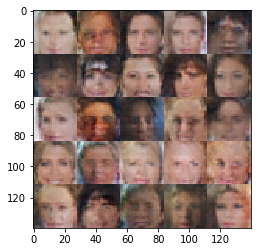

Step 4410 of Epoch 1/1... Discriminator Loss: 0.3714... Generator Loss: 1.7323
Step 4420 of Epoch 1/1... Discriminator Loss: 0.2942... Generator Loss: 2.3984
Step 4430 of Epoch 1/1... Discriminator Loss: 2.1481... Generator Loss: 6.2102
Step 4440 of Epoch 1/1... Discriminator Loss: 0.2131... Generator Loss: 5.5671
Step 4450 of Epoch 1/1... Discriminator Loss: 0.2952... Generator Loss: 3.2436
Step 4460 of Epoch 1/1... Discriminator Loss: 0.4762... Generator Loss: 1.5636
Step 4470 of Epoch 1/1... Discriminator Loss: 0.2911... Generator Loss: 2.3952
Step 4480 of Epoch 1/1... Discriminator Loss: 0.3612... Generator Loss: 1.7134
Step 4490 of Epoch 1/1... Discriminator Loss: 0.1573... Generator Loss: 8.0357
Step 4500 of Epoch 1/1... Discriminator Loss: 0.4076... Generator Loss: 1.6014


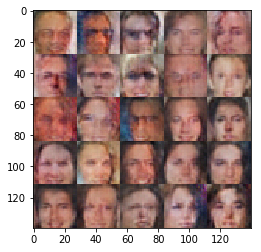

Step 4510 of Epoch 1/1... Discriminator Loss: 0.3717... Generator Loss: 1.7964
Step 4520 of Epoch 1/1... Discriminator Loss: 0.0888... Generator Loss: 4.0590
Step 4530 of Epoch 1/1... Discriminator Loss: 0.4243... Generator Loss: 7.9606
Step 4540 of Epoch 1/1... Discriminator Loss: 0.3148... Generator Loss: 3.2019
Step 4550 of Epoch 1/1... Discriminator Loss: 0.0611... Generator Loss: 4.0382
Step 4560 of Epoch 1/1... Discriminator Loss: 0.2313... Generator Loss: 2.4757
Step 4570 of Epoch 1/1... Discriminator Loss: 0.0505... Generator Loss: 3.7681
Step 4580 of Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 6.3396
Step 4590 of Epoch 1/1... Discriminator Loss: 0.2446... Generator Loss: 2.2343
Step 4600 of Epoch 1/1... Discriminator Loss: 0.0497... Generator Loss: 6.5229


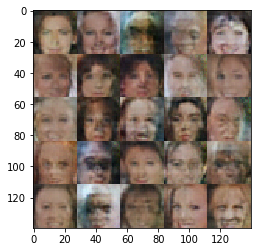

Step 4610 of Epoch 1/1... Discriminator Loss: 0.1310... Generator Loss: 3.5733
Step 4620 of Epoch 1/1... Discriminator Loss: 0.0390... Generator Loss: 4.6189
Step 4630 of Epoch 1/1... Discriminator Loss: 0.1138... Generator Loss: 4.2461
Step 4640 of Epoch 1/1... Discriminator Loss: 0.1285... Generator Loss: 3.0461
Step 4650 of Epoch 1/1... Discriminator Loss: 0.1401... Generator Loss: 2.7429
Step 4660 of Epoch 1/1... Discriminator Loss: 0.1967... Generator Loss: 2.5353
Step 4670 of Epoch 1/1... Discriminator Loss: 0.0735... Generator Loss: 5.0059
Step 4680 of Epoch 1/1... Discriminator Loss: 0.1115... Generator Loss: 3.7426
Step 4690 of Epoch 1/1... Discriminator Loss: 0.1960... Generator Loss: 3.0399
Step 4700 of Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 0.7716


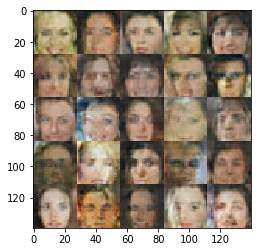

Step 4710 of Epoch 1/1... Discriminator Loss: 0.0670... Generator Loss: 4.2851
Step 4720 of Epoch 1/1... Discriminator Loss: 0.3706... Generator Loss: 4.5232
Step 4730 of Epoch 1/1... Discriminator Loss: 0.0708... Generator Loss: 3.6723
Step 4740 of Epoch 1/1... Discriminator Loss: 0.0342... Generator Loss: 6.6149
Step 4750 of Epoch 1/1... Discriminator Loss: 0.2279... Generator Loss: 2.2449
Step 4760 of Epoch 1/1... Discriminator Loss: 0.0312... Generator Loss: 5.5207
Step 4770 of Epoch 1/1... Discriminator Loss: 0.0917... Generator Loss: 4.2743
Step 4780 of Epoch 1/1... Discriminator Loss: 0.1455... Generator Loss: 3.2262
Step 4790 of Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 1.9895
Step 4800 of Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 1.0893


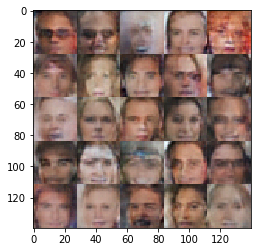

Step 4810 of Epoch 1/1... Discriminator Loss: 0.4672... Generator Loss: 1.6305
Step 4820 of Epoch 1/1... Discriminator Loss: 0.3939... Generator Loss: 1.6000
Step 4830 of Epoch 1/1... Discriminator Loss: 0.4424... Generator Loss: 1.3106


IndexError: list index out of range

In [18]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.6


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.